In [3]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [6]:
from src.utils.data_utils import load_csv

DATA_PATH = PROJECT_ROOT / "data" / "raw data" / "creditcard.csv"
df = load_csv(DATA_PATH)


2025-12-30 00:45:02,111 - INFO - Loading data from C:\Users\Josh\Desktop\fraud-detection\data\raw data\creditcard.csv
2025-12-30 00:45:05,358 - INFO - Loaded data shape: (284807, 31)


In [7]:
# Cell: Recreate train/test + model (for explainability)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Target and features
target = "Class"
X = df.drop(columns=[target])
y = df[target]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Train best-performing model (Random Forest)
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=1
)

rf.fit(X_train, y_train)

print("Random Forest re-trained for explainability")


Random Forest re-trained for explainability


In [8]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance.head(10)


,feature,importance
14,V14,0.172755
4,V4,0.115382
10,V10,0.111231
12,V12,0.093417
17,V17,0.092719
3,V3,0.064234
11,V11,0.058795
16,V16,0.051311
2,V2,0.028824
7,V7,0.025840


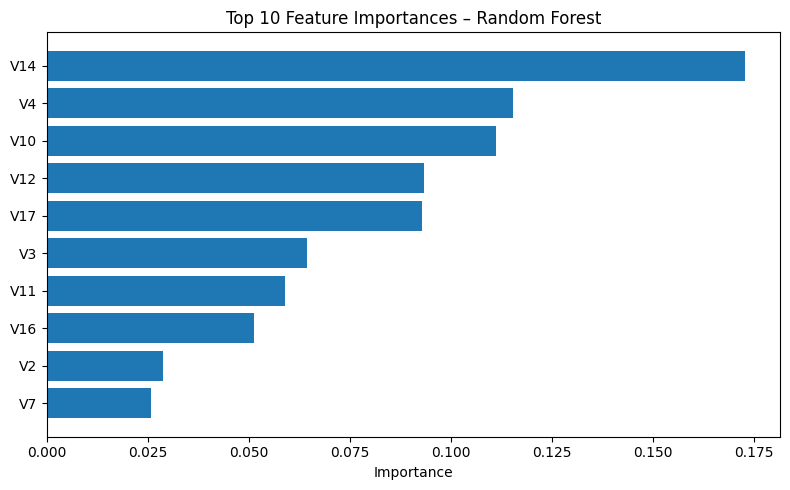

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(
    feature_importance.head(10)["feature"],
    feature_importance.head(10)["importance"]
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances – Random Forest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [10]:
import shap

# Use a small sample for speed
X_sample = X_test.sample(500, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

print("SHAP values computed")


SHAP values computed


In [12]:
type(shap_values), len(shap_values)


(numpy.ndarray, 500)

In [13]:
shap_values[1].shape, X_sample.shape


((30, 2), (500, 30))

In [14]:
# Handle different SHAP output formats safely
import numpy as np

if isinstance(shap_values, list):
    shap_vals_class1 = shap_values[1]
else:
    # If SHAP returns 3D array
    shap_vals_class1 = shap_values[:, :, 1]

print("SHAP values shape:", shap_vals_class1.shape)
print("X_sample shape:", X_sample.shape)


SHAP values shape: (500, 30)
X_sample shape: (500, 30)


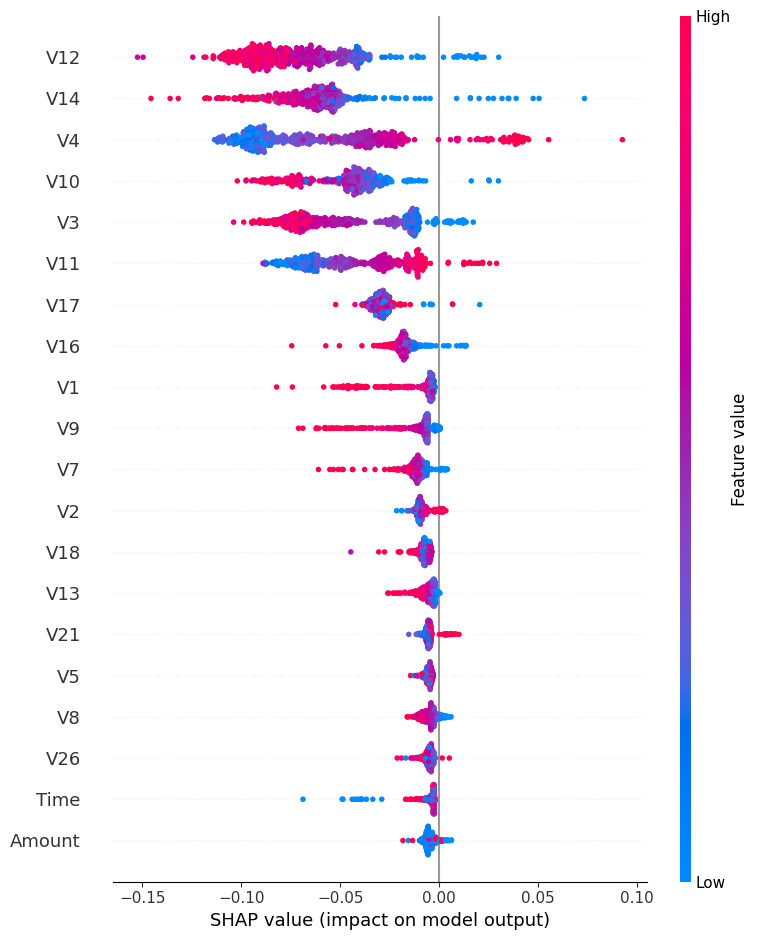

In [15]:
shap.summary_plot(
    shap_vals_class1,
    X_sample,
    show=True
)


Model Explainability

SHAP analysis was applied to the final Random Forest model to interpret feature contributions at both global and local levels. The SHAP summary plot highlights that a small subset of transaction-related features strongly influences fraud predictions. High absolute SHAP values correspond to anomalous transaction behavior, reinforcing model reliability and trustworthiness for deployment.